rs2525547 is on chrom 7:99551945 A>G, we use the cross validation fold with chrom 7 in test set (split 6)

In [1]:
snp='rs2525547'
split=6
snp_chrom="chr7"
snp_pos=99551945

In [2]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [3]:
from keras.models import load_model

Using TensorFlow backend.


In [4]:
import pysam
# SNP is at position 100 in the 200 bp MPRA construct 
def get_inputs(chrom,snp_pos,left_flank=99,right_flank=100,ref="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa"):
    ref=pysam.FastaFile(ref)
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    snp_pos=snp_pos-1 #convert to 0-indexing
    left_flank=ref.fetch(chrom,snp_pos-left_flank,snp_pos)
    print(len(left_flank))
    right_flank=ref.fetch(chrom,snp_pos+1,snp_pos+right_flank+1)
    print(len(right_flank))
    encoded=dict() 
    seqs=dict()
    for base in ['A','C','G','T']: 
        curseq=left_flank+base+right_flank
        seqs[base]=curseq
        encoded[base]=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    return encoded,seqs

In [5]:
##load the model 
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1

custom_objects={"sensitivity":tpr,
                "specificity":tnr,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1}

model=load_model("v4/gecco.classification.SummitWithin200bpCenter.7",custom_objects=custom_objects)

In [6]:
#get deepLIFT function 
from deeplift.conversion import kerasapi_conversion as kc
import keras.backend as K 
deeplift_model = kc.convert_model_from_saved_files("v4/gecco.classification.SummitWithin200bpCenter."+str(split),verbose=False)

In [7]:
#get the deeplift score with respect to the logit                                                                                                                    
score_func = deeplift_model.get_target_contribs_func(
find_scores_layer_idx=0,
    target_layer_idx=-2)


In [21]:
import numpy as np 
input_references = [np.array([0.3, 0.2, 0.2, 0.3])[None, None, None, :]]

 We have the fasta sequence from "CC_pilot-MPRA.fa"

>rs2525547_A_wC
TCAGCCTTCCAAAGCACTGGCATTACAGGTATGAACAACCATGCCTAGCCCCATATTAGTATTTTCCCTTTTTTTTTTTTTTGTACTTTTAGTAGAGTCAGGGTTTCACCATGTTAGCCAGGATGGTCTTGATCTCCTGACCTCGTAATCTGCCTGCCTTGGCCTCCCAAAGTGCTAGGATTACAGACGTGAGCCACCAC



In [22]:
mpra_seq="TCAGCCTTCCAAAGCACTGGCATTACAGGTATGAACAACCATGCCTAGCCCCATATTAGTATTTTCCCTTTTTTTTTTTTTTGTACTTTTAGTAGAGTCAGGGTTTCACCATGTTAGCCAGGATGGTCTTGATCTCCTGACCTCGTAATCTGCCTGCCTTGGCCTCCCAAAGTGCTAGGATTACAGACGTGAGCCACCAC"

In [23]:
len(mpra_seq)

200

In [24]:
mpra_seq[99] #reference allele "C" at position 100 in the sequence , 99 bp left flank, 100 bp right flank 

'A'

In [25]:
## extract the 1kb region centered at the SNP 
import numpy as np 
X,seqs=get_inputs(snp_chrom,snp_pos)


99
100


In [26]:
X['A'].shape

(1, 1, 200, 4)

In [27]:
seqs['A']

'tcagccttccaaagcactggcattacaggtatgaacaaccatgcctagccCCATATTAGTATTTTCCCTTTTTTTTttttttgtacttttagtagagtcAgggtttcaccatgttagccaggatggtcttgatctcctgacctcgtaatctgcctgccttggcctcccaaagtgctaggattacagacgtgagccaccac'

In [28]:
#verify we have extracted the same sequence that was used in the MPRA 
seqs['A'].upper()==mpra_seq.upper()

True

In [29]:
#Now, pad to 1000 bp by using a 500 bp flank 
X,seqs=get_inputs(snp_chrom,snp_pos,left_flank=499,right_flank=500)
X['A'].shape

499
500


(1, 1, 1000, 4)

In [30]:
## pretty print
tasks=["Healthy","Tumor","SW480","HCT116","COLO205"]
print('\t'+'\t'.join(tasks))
for base in ['A','C','G','T']:
    print(base+'\t'+'\t'.join([str(round(i,3)) for i in model.predict(X[base])[0]]))

	Healthy	Tumor	SW480	HCT116	COLO205
A	0.0	0.0	0.001	0.004	0.0
C	0.0	0.0	0.001	0.003	0.001
G	0.0	0.0	0.001	0.003	0.0
T	0.0	0.0	0.001	0.003	0.0


In [31]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_A=dict() 
for t_index in range(5):
    dl_scores_A[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['A']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [32]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_C=dict() 
for t_index in range(5):
    dl_scores_C[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['C']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [33]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_G=dict() 
for t_index in range(5):
    dl_scores_G[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['G']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [34]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_T=dict() 
for t_index in range(5):
    dl_scores_T[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['T']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [35]:
from dragonn.tutorial_utils import  plot_seq_importance

/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Healthy DeepLIFT Scores 

In [83]:
ylim=(-.25,0.25)

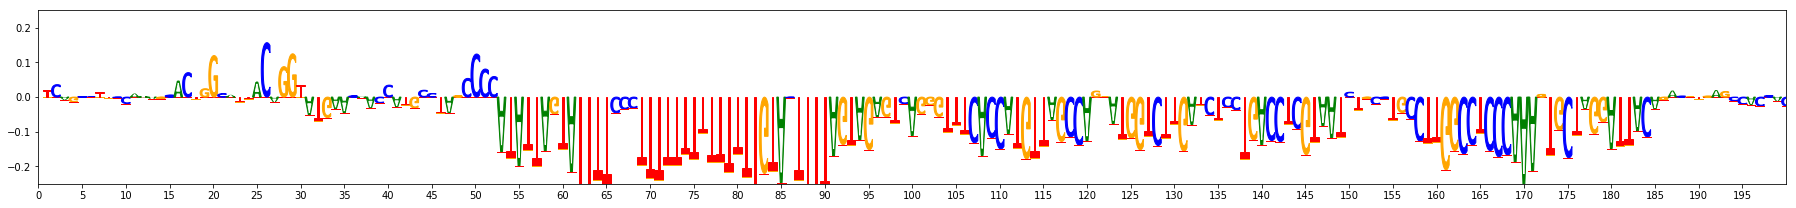

In [84]:
tmp1=dl_scores_A['Healthy'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=ylim)

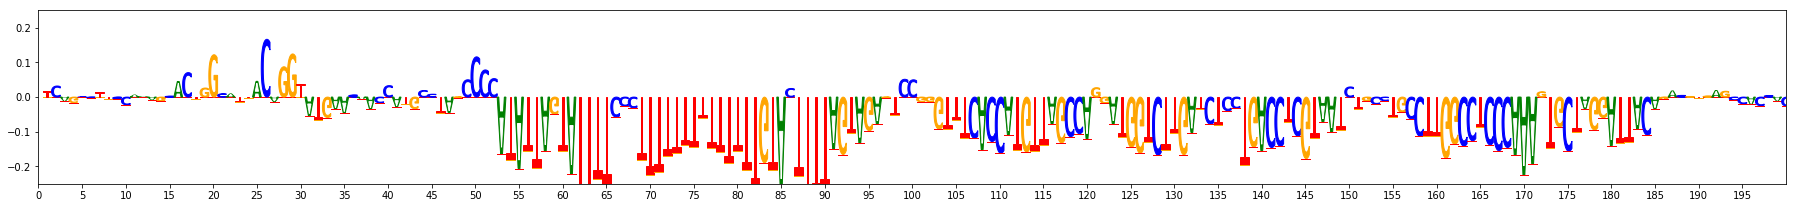

In [85]:
tmp3=dl_scores_C['Healthy'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=ylim)

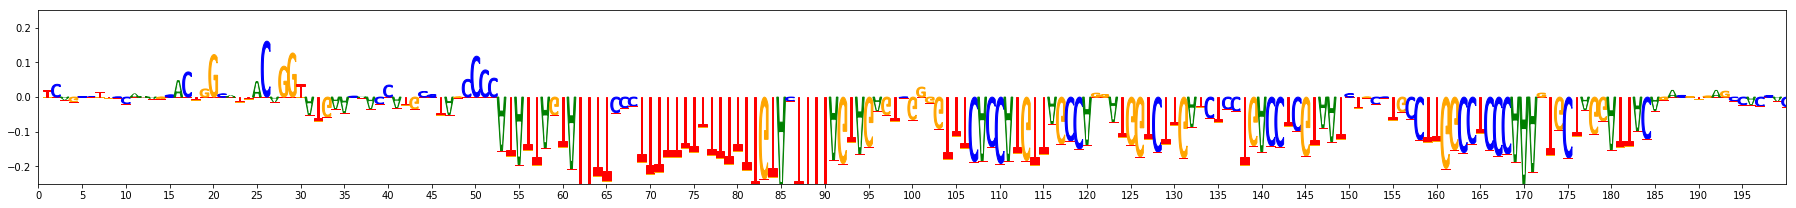

In [86]:
tmp5=dl_scores_G['Healthy'][0].squeeze()[400:600]
tmp6=X['G'].squeeze()[400:600]
plot_seq_importance(tmp5,tmp6,ylim=ylim)

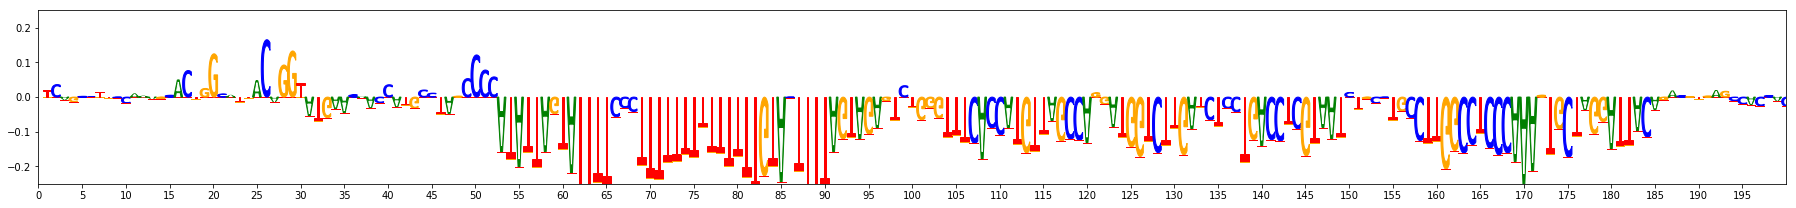

In [87]:
tmp7=dl_scores_T['Healthy'][0].squeeze()[400:600]
tmp8=X['T'].squeeze()[400:600]
plot_seq_importance(tmp7,tmp8,ylim=ylim)

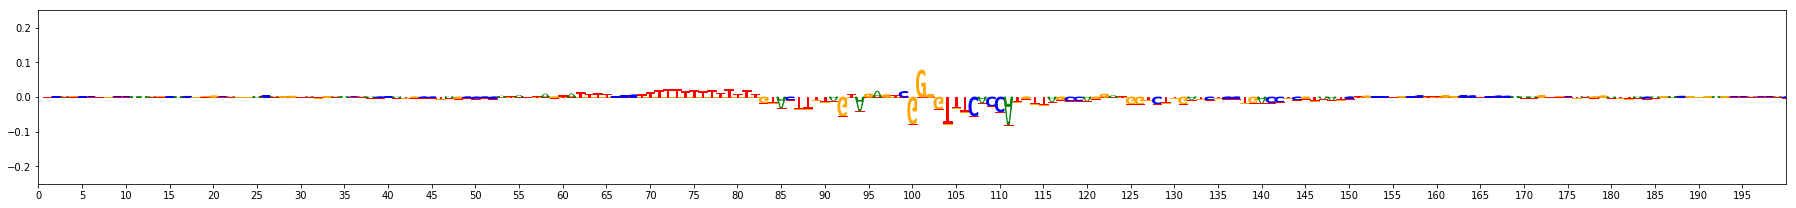

In [88]:
#delta track for the alternate G allele - reference A allele (with G at position 100)
plot_seq_importance(tmp5-tmp1,tmp6,ylim=ylim)

## Tumor

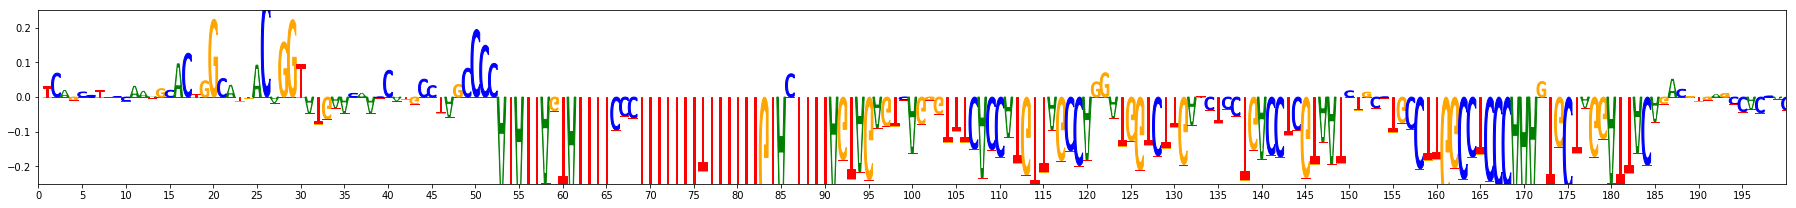

In [89]:
tmp1=dl_scores_A['Tumor'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=ylim)

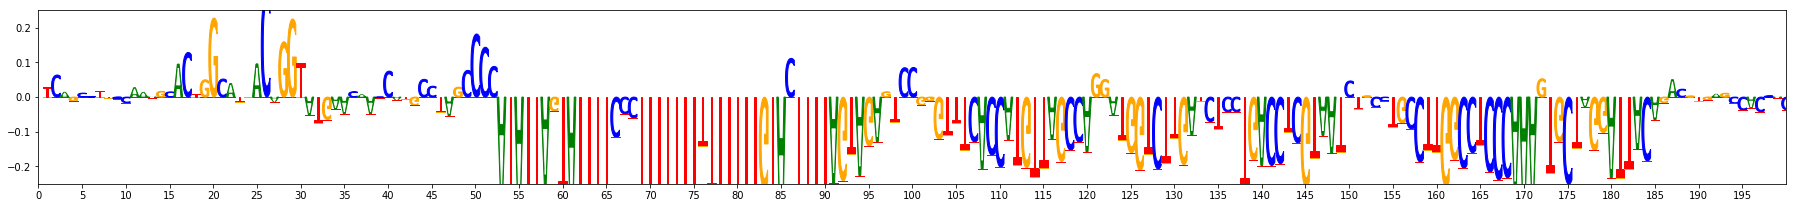

In [90]:
tmp3=dl_scores_C['Tumor'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=ylim)

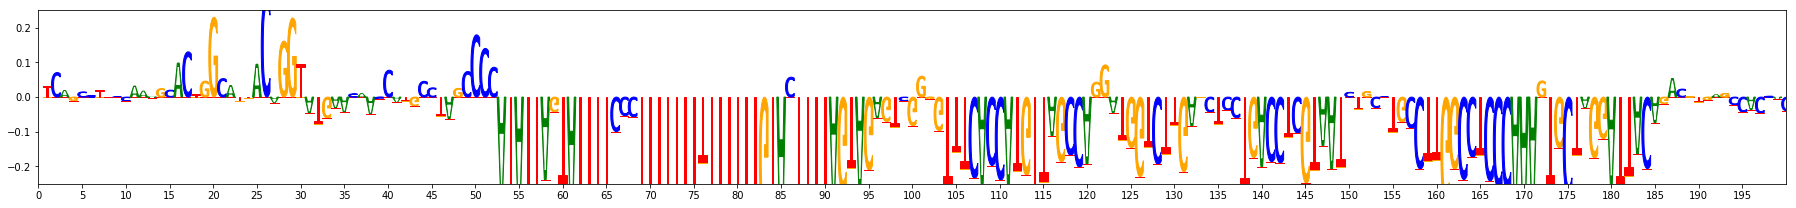

In [91]:
tmp5=dl_scores_G['Tumor'][0].squeeze()[400:600]
tmp6=X['G'].squeeze()[400:600]
plot_seq_importance(tmp5,tmp6,ylim=ylim)

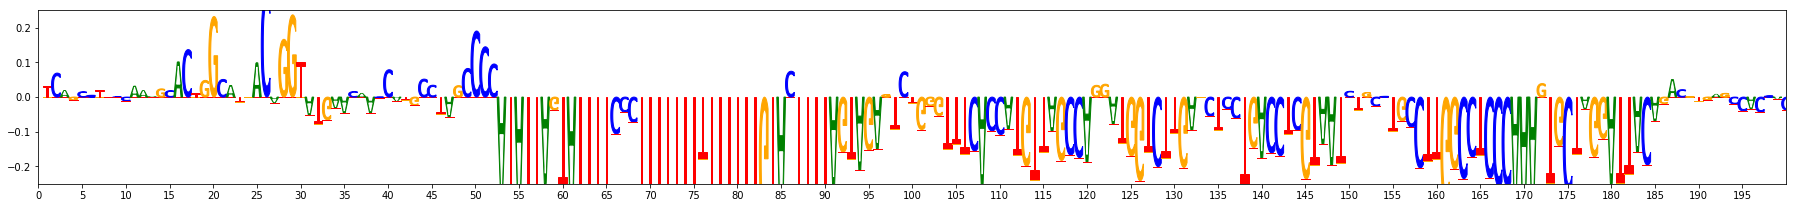

In [92]:
tmp7=dl_scores_T['Tumor'][0].squeeze()[400:600]
tmp8=X['T'].squeeze()[400:600]
plot_seq_importance(tmp7,tmp8,ylim=ylim)

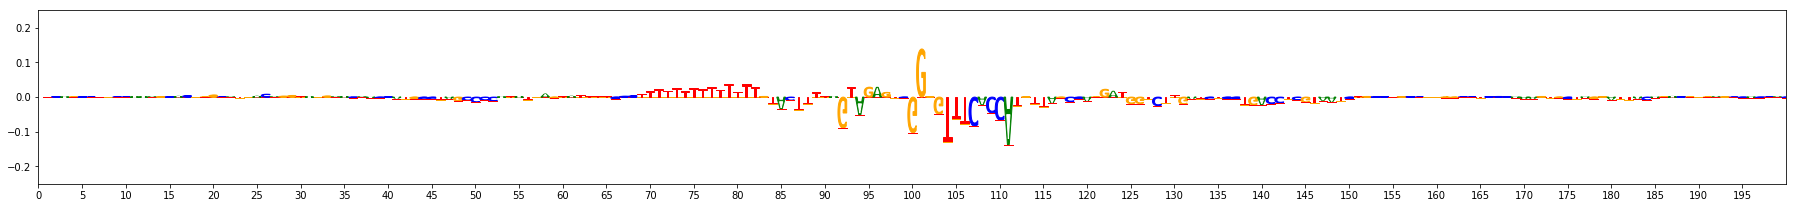

In [93]:
#delta track for the alternate G allele - reference C allele (with G at position 100)
plot_seq_importance(tmp5-tmp1,tmp6,ylim=ylim)

## SW480

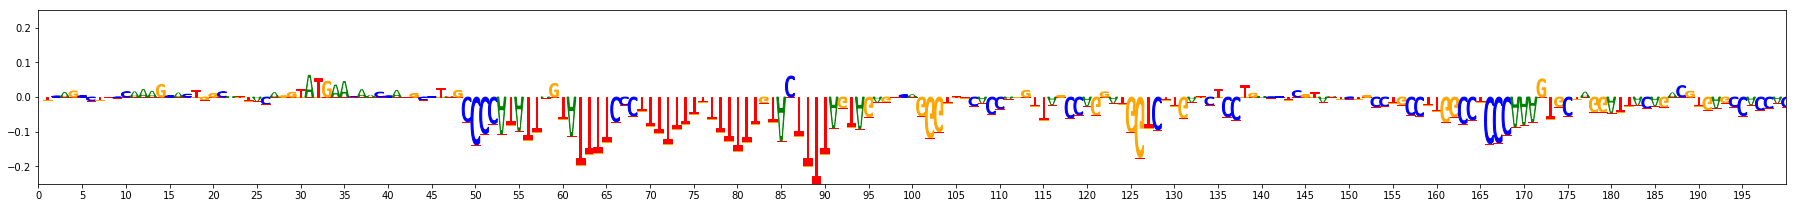

In [94]:
tmp1=dl_scores_A['SW480'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=ylim)

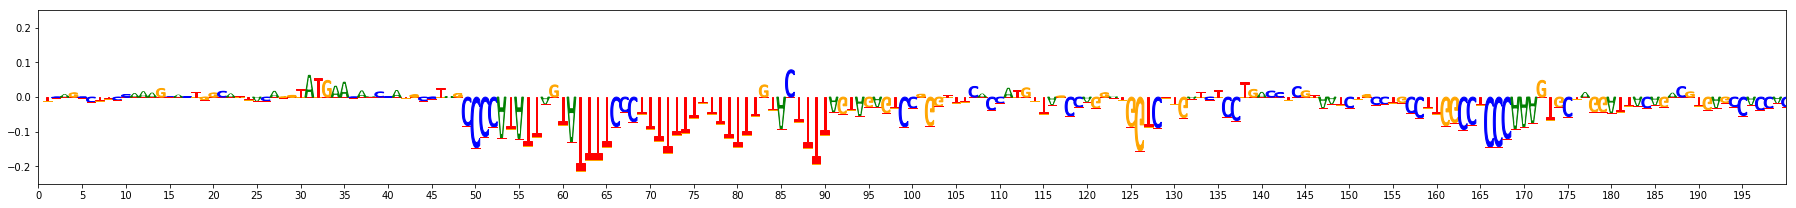

In [95]:
tmp3=dl_scores_C['SW480'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=ylim)

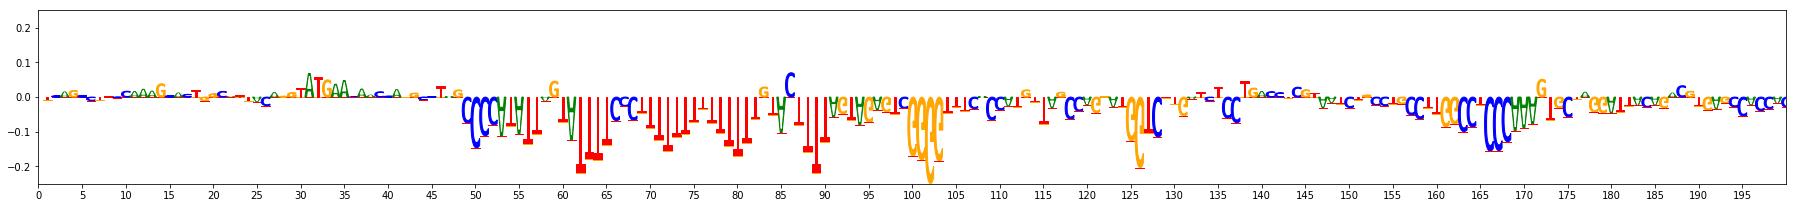

In [96]:
tmp5=dl_scores_G['SW480'][0].squeeze()[400:600]
tmp6=X['G'].squeeze()[400:600]
plot_seq_importance(tmp5,tmp6,ylim=ylim)

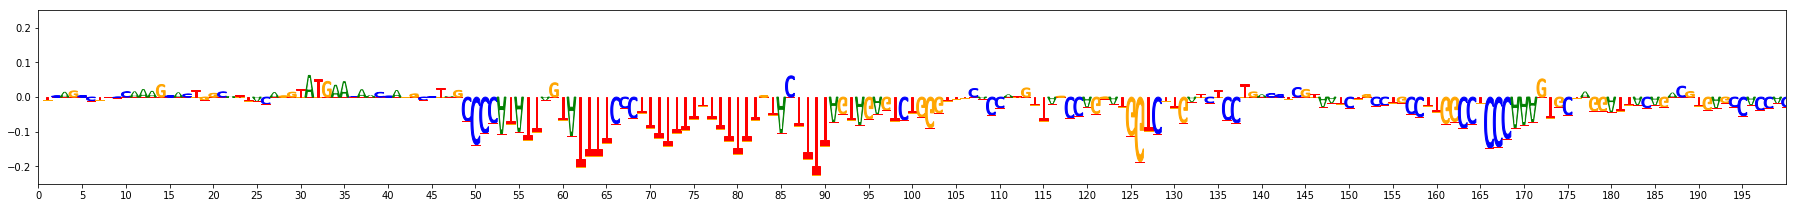

In [97]:
tmp7=dl_scores_T['SW480'][0].squeeze()[400:600]
tmp8=X['T'].squeeze()[400:600]
plot_seq_importance(tmp7,tmp8,ylim=ylim)

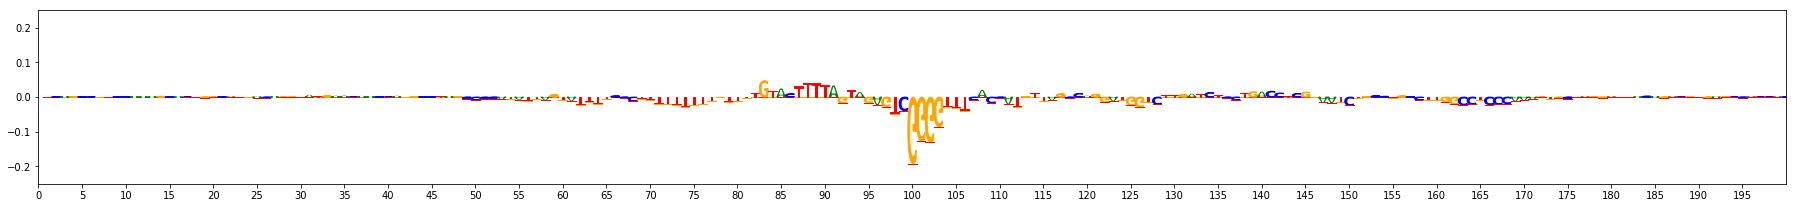

In [98]:
#delta track for the alternate G allele - reference C allele (with G at position 100)
plot_seq_importance(tmp5-tmp1,tmp6,ylim=ylim)

## COLO205

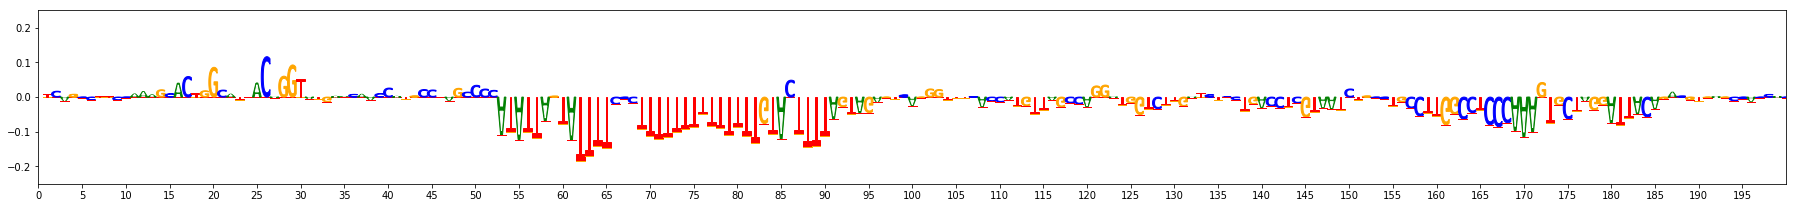

In [99]:
tmp1=dl_scores_A['COLO205'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=ylim)

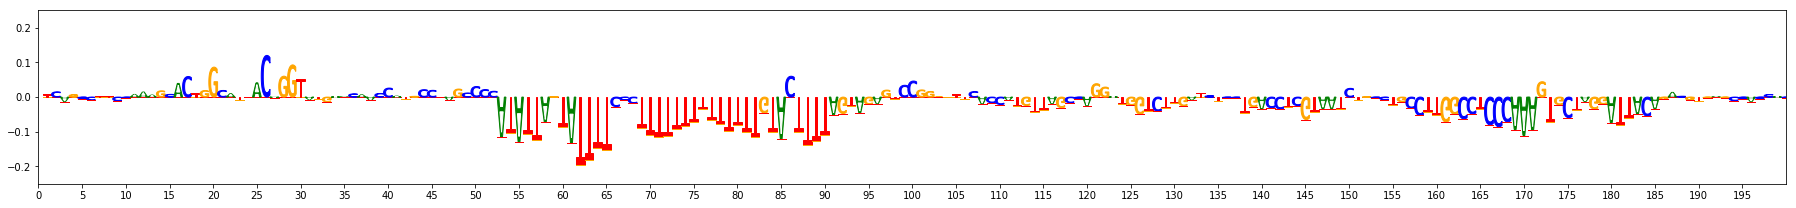

In [100]:
tmp3=dl_scores_C['COLO205'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=ylim)

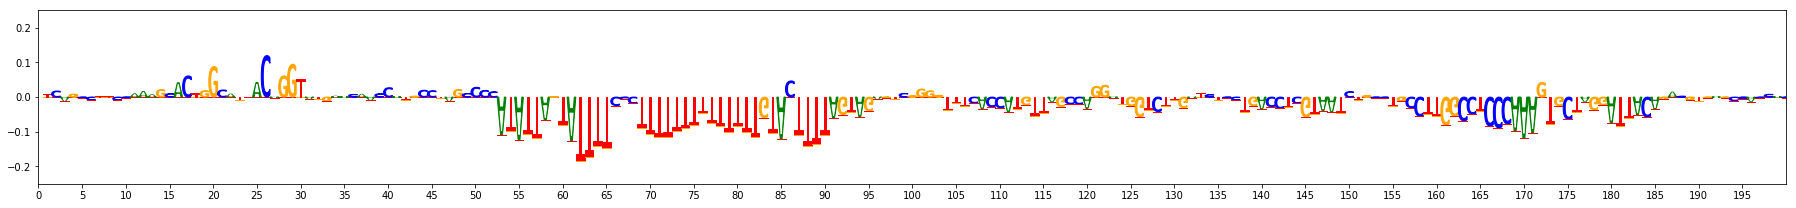

In [101]:
tmp5=dl_scores_G['COLO205'][0].squeeze()[400:600]
tmp6=X['G'].squeeze()[400:600]
plot_seq_importance(tmp5,tmp6,ylim=ylim)

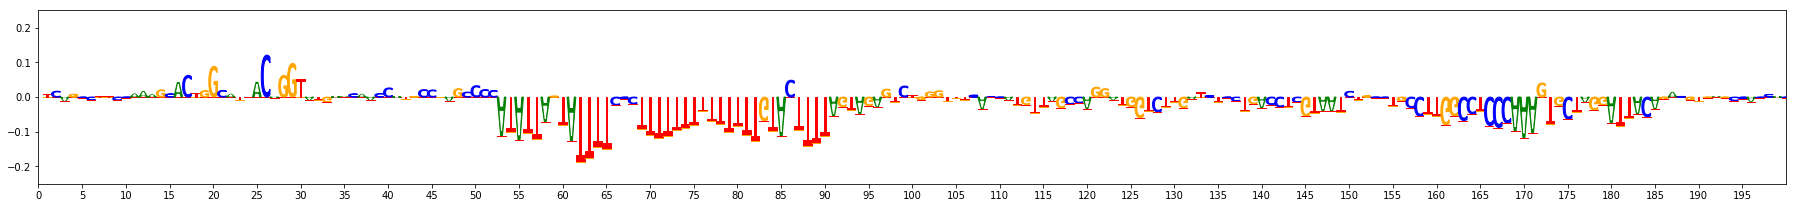

In [102]:
tmp7=dl_scores_T['COLO205'][0].squeeze()[400:600]
tmp8=X['T'].squeeze()[400:600]
plot_seq_importance(tmp7,tmp8,ylim=ylim)

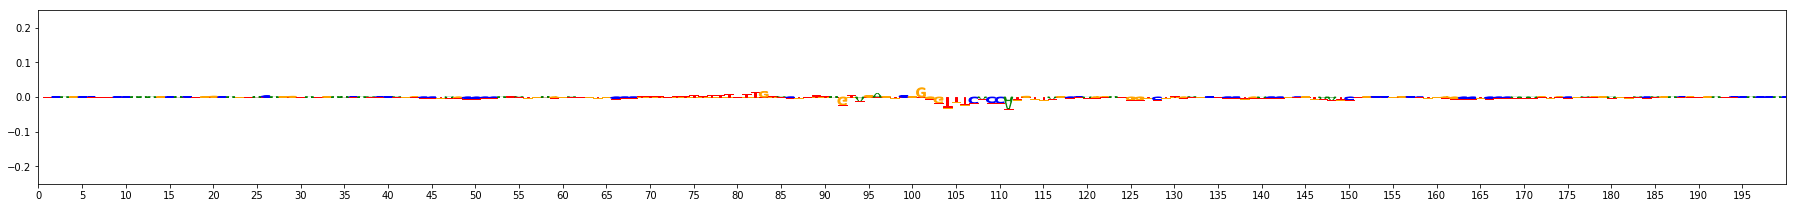

In [103]:
#delta track for the alternate G allele - reference C allele (with G at position 100)
plot_seq_importance(tmp5-tmp1,tmp6,ylim=ylim)

## HCT116

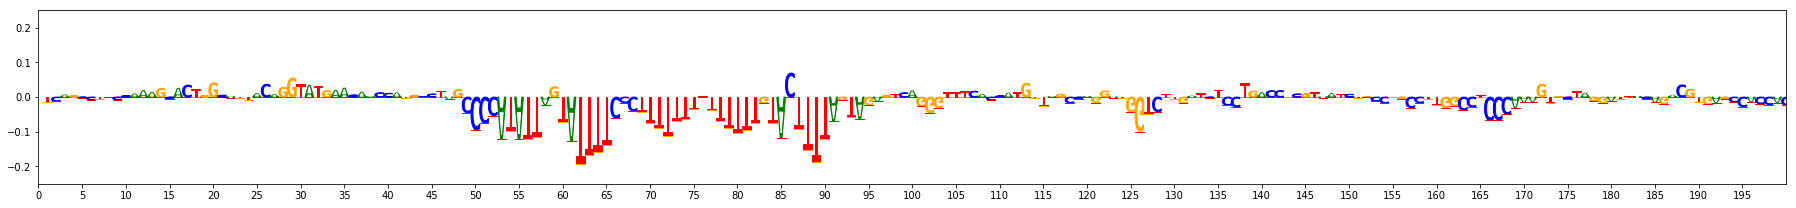

In [104]:
tmp1=dl_scores_A['HCT116'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=ylim)

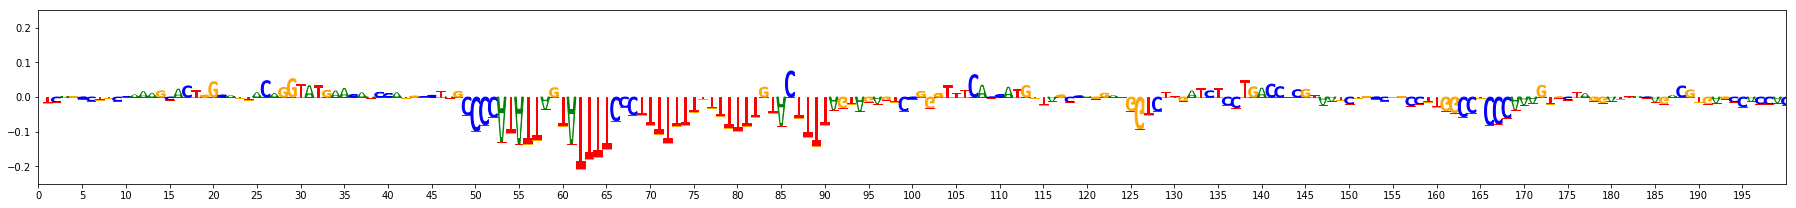

In [105]:
tmp3=dl_scores_C['HCT116'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=ylim)

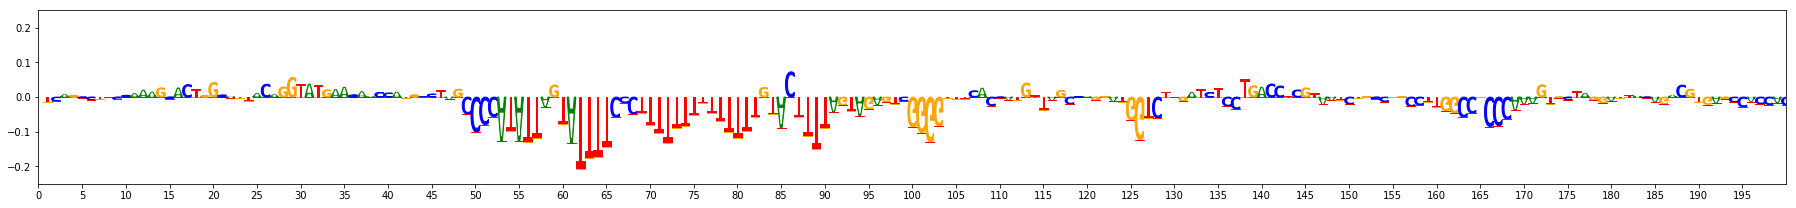

In [106]:
tmp5=dl_scores_G['HCT116'][0].squeeze()[400:600]
tmp6=X['G'].squeeze()[400:600]
plot_seq_importance(tmp5,tmp6,ylim=ylim)

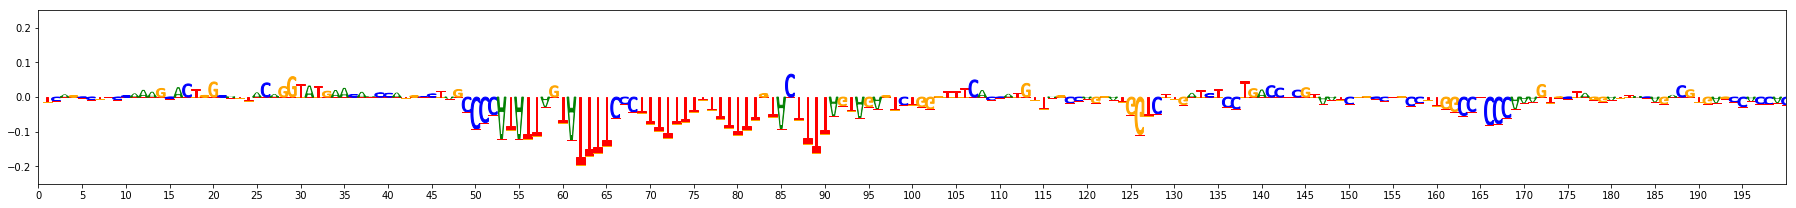

In [107]:
tmp7=dl_scores_T['HCT116'][0].squeeze()[400:600]
tmp8=X['T'].squeeze()[400:600]
plot_seq_importance(tmp7,tmp8,ylim=ylim)

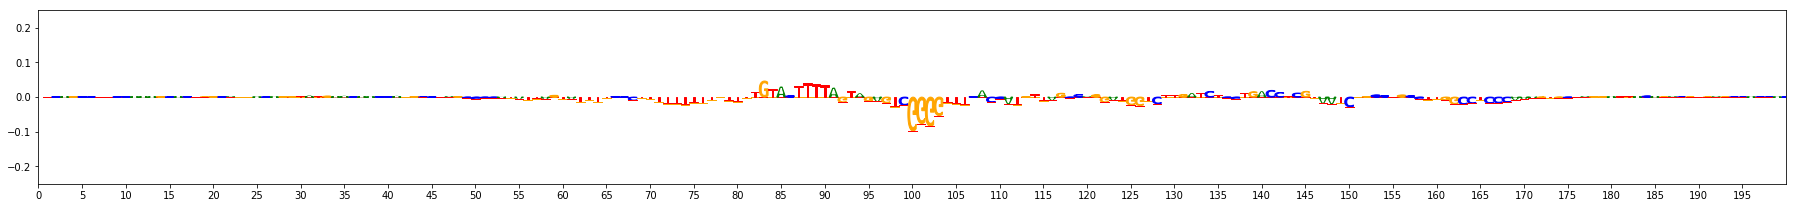

In [108]:
#delta track for the alternate G allele - reference C allele (with G at position 100)
plot_seq_importance(tmp5-tmp1,tmp6,ylim=ylim)

In [109]:
import pandas as pd 
mpra=pd.read_csv("/srv/scratch/annashch/gecco/20190207_Pilot_Data_Freeze_1/CC_Pilot_HCT116_SNPS_20180208.out",header=0,sep='\t')

In [110]:
mpra[mpra['SNP']==snp][['SNP','window','strand','allele','A.log2FC','B.log2FC']]

,SNP,window,strand,allele,A.log2FC,B.log2FC
584,rs2525547,center,fwd,ref,0.325385,0.609386
585,rs2525547,center,rev,ref,1.055124,1.109335
586,rs2525547,left,fwd,ref,0.292252,0.152135
587,rs2525547,left,rev,ref,1.239615,1.181745
588,rs2525547,right,fwd,ref,0.704391,0.555807
589,rs2525547,right,rev,ref,1.001280,1.208470


In [111]:
import pandas as pd 
mpra=pd.read_csv("/srv/scratch/annashch/gecco/20190207_Pilot_Data_Freeze_1/CC_Pilot_SW480_SNPS_20180208.out",header=0,sep='\t')

In [112]:
mpra[mpra['SNP']==snp][['SNP','window','strand','allele','A.log2FC','B.log2FC']]

,SNP,window,strand,allele,A.log2FC,B.log2FC
584,rs2525547,center,fwd,ref,0.138338,0.318085
585,rs2525547,center,rev,ref,0.347780,0.377148
586,rs2525547,left,fwd,ref,0.303825,0.438256
587,rs2525547,left,rev,ref,0.533859,0.804245
588,rs2525547,right,fwd,ref,0.580287,0.723303
589,rs2525547,right,rev,ref,0.670165,0.751123
